<a href="https://colab.research.google.com/github/NouamaneTazi/NLP/blob/master/scipy_HAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk, re
import matplotlib.pyplot as plt

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Testing HAC

In [6]:
corpus = ['The sky is blue and beautiful.',
'Love this blue and beautiful sky!',
'The quick brown fox jumps over the lazy dog.',
"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
'I love green eggs, ham, sausages and bacon!',
'The brown fox is quick and the blue dog is lazy!',
'The sky is very blue and the sky is very beautiful today',
'The dog is lazy but the brown fox is quick!'
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals',
'weather', 'animals']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, e...",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beaut...,weather
7,The dog is lazy but the brown fox is quick!,animals


In [0]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
def normalize_document(doc):
    # lowercase and remove special characters\whitespace
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc
normalize_corpus = np.vectorize(normalize_document) 

In [16]:
norm_corpus = normalize_corpus(corpus)
norm_corpus

array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog',
       'kings breakfast sausages ham bacon eggs toast beans',
       'love green eggs ham sausages bacon',
       'brown fox quick blue dog lazy', 'sky blue sky beautiful today',
       'dog lazy brown fox quick'], dtype='<U51')

In [19]:
tv = TfidfVectorizer(min_df=0., max_df=1., norm='l2', use_idf=True, smooth_idf=True)
tv_matrix = tv.fit_transform(norm_corpus)
tv_matrix = tv_matrix.toarray()
vocab = tv.get_feature_names()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)

,bacon,beans,beautiful,blue,breakfast,brown,dog,eggs,fox,green,ham,jumps,kings,lazy,love,quick,sausages,sky,toast,today
0,0.00,0.00,0.60,0.53,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.60,0.00,0.0
1,0.00,0.00,0.49,0.43,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.57,0.00,0.00,0.49,0.00,0.0
2,0.00,0.00,0.00,0.00,0.00,0.38,0.38,0.00,0.38,0.00,0.00,0.53,0.00,0.38,0.00,0.38,0.00,0.00,0.00,0.0
3,0.32,0.38,0.00,0.00,0.38,0.00,0.00,0.32,0.00,0.00,0.32,0.00,0.38,0.00,0.00,0.00,0.32,0.00,0.38,0.0
4,0.39,0.00,0.00,0.00,0.00,0.00,0.00,0.39,0.00,0.47,0.39,0.00,0.00,0.00,0.39,0.00,0.39,0.00,0.00,0.0
5,0.00,0.00,0.00,0.37,0.00,0.42,0.42,0.00,0.42,0.00,0.00,0.00,0.00,0.42,0.00,0.42,0.00,0.00,0.00,0.0
6,0.00,0.00,0.36,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.72,0.00,0.5
7,0.00,0.00,0.00,0.00,0.00,0.45,0.45,0.00,0.45,0.00,0.00,0.00,0.00,0.45,0.00,0.45,0.00,0.00,0.00,0.0


In [21]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(tv_matrix)
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df

,0,1,2,3,4,5,6,7
0,1.000000,0.820599,0.000000,0.000000,0.000000,0.192353,0.817246,0.000000
1,0.820599,1.000000,0.000000,0.000000,0.225489,0.157845,0.670631,0.000000
2,0.000000,0.000000,1.000000,0.000000,0.000000,0.791821,0.000000,0.850516
3,0.000000,0.000000,0.000000,1.000000,0.506866,0.000000,0.000000,0.000000
4,0.000000,0.225489,0.000000,0.506866,1.000000,0.000000,0.000000,0.000000
5,0.192353,0.157845,0.791821,0.000000,0.000000,1.000000,0.115488,0.930989
6,0.817246,0.670631,0.000000,0.000000,0.000000,0.115488,1.000000,0.000000
7,0.000000,0.000000,0.850516,0.000000,0.000000,0.930989,0.000000,1.000000


In [22]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(similarity_matrix, 'ward')
pd.DataFrame(Z, columns=['Document\Cluster 1', 'Document\Cluster 2',
'Distance', 'Cluster Size'], dtype='object')

,Document\Cluster 1,Document\Cluster 2,Distance,Cluster Size
0,2,7,0.253098,2
1,0,6,0.308539,2
2,5,8,0.386952,3
3,1,9,0.489845,3
4,3,4,0.732945,2
5,11,12,2.69565,5
6,10,13,3.45108,8


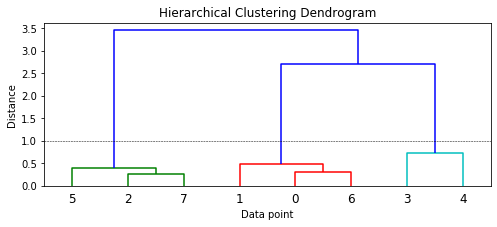

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data point')
plt.ylabel('Distance')
dendrogram(Z)
plt.axhline(y=1.0, c='k', ls='--', lw=0.5)

the linkage matrix tells us which data points (or clusters) were merged.

In [25]:
from scipy.cluster.hierarchy import fcluster
max_dist = 1.0
cluster_labels = fcluster(Z, max_dist, criterion='distance')
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,2
1,Love this blue and beautiful sky!,weather,2
2,The quick brown fox jumps over the lazy dog.,animals,1
3,"A king's breakfast has sausages, ham, bacon, e...",food,3
4,"I love green eggs, ham, sausages and bacon!",food,3
5,The brown fox is quick and the blue dog is lazy!,animals,1
6,The sky is very blue and the sky is very beaut...,weather,2
7,The dog is lazy but the brown fox is quick!,animals,1


# 20 News Groups Dataset

## Load Data

In [0]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np

In [0]:
data = fetch_20newsgroups(subset='all', shuffle=True, remove=('headers', 'footers', 'quotes'))
data_labels_map = dict(enumerate(data.target_names))

In [5]:
# building the dataframe
corpus, target_labels, target_names = (data.data, data.target, [data_labels_map[label] for label in data.target])
data_df = pd.DataFrame({'Article': corpus, 'Target Label': target_labels, 'Target Name': target_names})
print(data_df.shape)
data_df.head(10)

(18846, 3)


,Article,Target Label,Target Name
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware
5,\n\nBack in high school I worked as a lab assi...,12,sci.electronics
6,\n\nAE is in Dallas...try 214/241-6060 or 214/...,4,comp.sys.mac.hardware
7,"\n[stuff deleted]\n\nOk, here's the solution t...",10,rec.sport.hockey
8,"\n\n\nYeah, it's the second one. And I believ...",10,rec.sport.hockey
9,\nIf a Christian means someone who believes in...,19,talk.religion.misc


## Preprocess Data

In [0]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
def normalize_document(doc):
    # lowercase and remove special characters\whitespace
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc
normalize_corpus = np.vectorize(normalize_document) 

In [7]:
norm_corpus = normalize_corpus(corpus)
norm_corpus[:10]

array(['sure bashers pens fans pretty confused lack kind posts recent pens massacre devils actually bit puzzled bit relieved however going put end nonpittsburghers relief bit praise pens man killing devils worse thought jagr showed much better regular season stats also lot fo fun watch playoffs bowman let jagr lot fun next couple games since pens going beat pulp jersey anyway disappointed see islanders lose final regular season game pens rule',
       'brother market highperformance video card supports vesa local bus mb ram anyone suggestionsideas diamond stealth pro local bus orchid farenheit ati graphics ultra pro highperformance vlb card please post email thank matt',
       'finally said dream mediterranean new area greater years like holocaust numbers ist july usa sweden april still cold changed calendar nothing mentioned true let say true shall azeri women children going pay price raped killed tortured armenians hearded something called geneva convention facist ohhh forgot armeni

## Extracting TF-IDF vectors 

In [11]:
tv = TfidfVectorizer(min_df=0.01, max_df=1.0, norm='l2', use_idf=True, smooth_idf=True)
tv_matrix = tv.fit_transform(norm_corpus)
tv_matrix = tv_matrix.toarray()
vocab = tv.get_feature_names()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)

,10,11,12,13,14,15,16,18,20,24,ability,able,absolutely,accept,accepted,access,according,account,across,act,action,actions,actual,actually,add,added,addition,additional,address,admit,advance,advice,age,ago,agree,air,al,algorithm,allow,allowed,...,wide,wife,willing,win,window,windows,wish,within,without,women,wonder,wondering,wont,word,words,work,worked,working,works,world,worse,worth,would,wouldnt,write,writing,written,wrong,wrote,yeah,year,years,yes,yet,york,youd,youll,young,youre,youve
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.16,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.12,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.08,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.09,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.11,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.11,0.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.10,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
18842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
18843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.20,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.23,0.0,0.0,0.0,0.0,0.0,0.0
18844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.20,0.0,0.0,0.0,0.18,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0


## Document similarity

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(tv_matrix)
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,18806,18807,18808,18809,18810,18811,18812,18813,18814,18815,18816,18817,18818,18819,18820,18821,18822,18823,18824,18825,18826,18827,18828,18829,18830,18831,18832,18833,18834,18835,18836,18837,18838,18839,18840,18841,18842,18843,18844,18845
0,1.000000,0.000000,0.051479,0.000000,0.000000,0.022060,0.000000,0.082056,0.017286,0.000000,0.000000,0.000000,0.055740,0.000000,0.000000,0.053523,0.014671,0.000000,0.063270,0.053250,0.045520,0.000000,0.006337,0.000000,0.021225,0.023608,0.033852,0.000000,0.078689,0.023656,0.057144,0.026326,0.000000,0.028759,0.000000,0.000000,0.018318,0.000000,0.027554,0.032378,...,0.020521,0.000000,0.094324,0.010225,0.024031,0.000000,0.028271,0.035631,0.042620,0.024069,0.013038,0.024349,0.050053,0.063314,0.014411,0.000000,0.018627,0.025591,0.025127,0.076338,0.026302,0.000000,0.000000,0.049212,0.0,0.045336,0.019020,0.000000,0.000000,0.000000,0.088997,0.000000,0.050654,0.007811,0.066219,0.055728,0.000000,0.000000,0.012497,0.025386
1,0.000000,1.000000,0.000000,0.318765,0.027691,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003792,0.000000,0.000000,0.000000,0.000000,0.000000,0.009842,0.000000,0.014593,0.000000,0.059013,0.000000,0.000000,0.074866,0.000000,0.000000,0.539814,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.164692,0.019389,0.127025,0.068066,0.000000,0.021280,0.096969,0.000000,0.054991,0.000000,0.032504,0.029901,0.000000,0.057554,0.000000,0.000000,0.501080,0.000000,0.000000,0.128755,0.000000,0.015965,0.073617,0.0,0.000000,0.000000,0.027575,0.000000,0.000000,0.045734,0.000000,0.000000,0.016799,0.015472,0.000000,0.000000,0.000000,0.000000,0.020066
2,0.051479,0.000000,1.000000,0.003368,0.025525,0.000000,0.128557,0.045110,0.092990,0.024559,0.016758,0.089335,0.053046,0.000000,0.000000,0.051664,0.000000,0.011063,0.171303,0.036929,0.039490,0.048923,0.023902,0.058142,0.073137,0.013749,0.061347,0.000000,0.000000,0.052623,0.032606,0.000000,0.000000,0.052380,0.068025,0.010481,0.008040,0.024294,0.061193,0.033710,...,0.000000,0.000000,0.000000,0.077150,0.017042,0.023190,0.055973,0.015494,0.032331,0.045370,0.062747,0.101170,0.000000,0.027244,0.054836,0.033538,0.196753,0.046201,0.000000,0.000000,0.044340,0.049423,0.010888,0.052954,0.0,0.000000,0.019679,0.000000,0.000000,0.041334,0.051207,0.041155,0.095702,0.092463,0.064377,0.136817,0.032202,0.000000,0.000000,0.040777
3,0.000000,0.318765,0.003368,1.000000,0.037328,0.010693,0.000000,0.009197,0.014807,0.013408,0.022926,0.000000,0.017801,0.066774,0.000000,0.007481,0.119204,0.010443,0.027458,0.016882,0.011720,0.000000,0.007796,0.005358,0.003790,0.000000,0.008375,0.014638,0.290455,0.000000,0.058609,0.000000,0.000000,0.020670,0.000000,0.000000,0.000000,0.000000,0.009537,0.021885,...,0.000000,0.133604,0.012254,0.053289,0.000000,0.000000,0.012209,0.036870,0.000000,0.000000,0.000000,0.013583,0.008271,0.000000,0.001614,0.000000,0.006058,0.257358,0.000000,0.022682,0.019704,0.000000,0.026765,0.047212,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007854,0.019722,0.007977,0.011277,0.010509,0.000000,0.000000,0.013607
4,0.000000,0.027691,0.025525,0.037328,1.000000,0.042078,0.038331,0.014346,0.017940,0.000000,0.042620,0.000000,0.110677,0.062066,0.000000,0.000000,0.186143,0.037500,0.022916,0.034826,0.107433,0.071183,0.043144,0.000000,0.039689,0.143000,0.000000,0.027212,0.044338,0.055745,0.013843,0.024475,0.025927,0.000000,0.057438,0.028328,0.021732,0.000000,0.019112,0.070572,...,0.117952,0.075455,0.000000,0.092199,0.050513,0.000000,0.077929,0.008642,0.030302,0.095857,0.014064,0.071202,0.023038,0.000000,0.077457,0.033048,0.023197,0.031720,0.000000,0.000000,0.076344,0.035237,0.039377,0.201836,0.0,0.133053,0.063479,0.000000,0.000000,0.000000,0.000000,0.027462,0.032331,0.043818,0.043960,0.027350,0.019535,0.043604,0.000000,0.075328
...,...,...,...,...,...,...,...,...,...,

## HAC (hierarchical agglomerative clustering)

the linkage matrix tells us which data points (or clusters) were merged.

In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(similarity_matrix, 'ward')
pd.DataFrame(Z, columns=['Document\Cluster 1', 'Document\Cluster 2',
'Distance', 'Cluster Size'], dtype='object')

,Document\Cluster 1,Document\Cluster 2,Distance,Cluster Size
0,1699,15896,0,2
1,91,104,0,2
2,127,18847,0,3
3,135,18848,0,4
4,161,18849,0,5
...,...,...,...,...
18840,37675,37685,107.908,5545
18841,37670,37682,124.041,8354
18842,37669,37686,126.669,6334
18843,37684,37687,145.775,12512


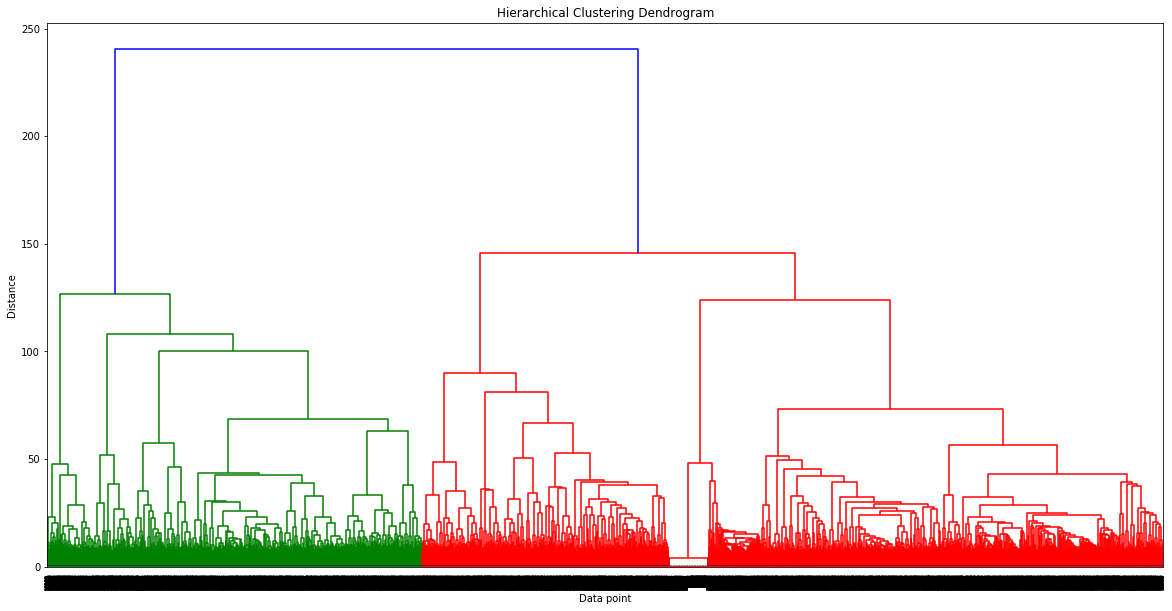

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data point')
plt.ylabel('Distance')
dendrogram(Z)
plt.axhline(y=1.0, c='k', ls='--', lw=0.5)

In [29]:
from scipy.cluster.hierarchy import fcluster
max_dist = 49
cluster_labels = fcluster(Z, max_dist, criterion='distance')
max(cluster_labels)

20

In [27]:
data_df['Target Label'].describe()

count    18846.000000
mean         9.293166
std          5.562798
min          0.000000
25%          5.000000
50%          9.000000
75%         14.000000
max         19.000000
Name: Target Label, dtype: float64

In [0]:
cluster_labels = cluster_labels['ClusterLabel']
D = {}
i = 0
while i<len(cluster_labels):
    if cluster_labels[i] not in D or data_df['Target Name'][i] not in D.values():
        D[cluster_labels[i]] = data_df['Target Name'][i]
    i+=1
D

In [87]:
cluster_labels_df = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
cluster_names_df = pd.DataFrame([D[label] for label in cluster_labels], columns=['ClusterName'])
result_df = pd.concat([data_df, cluster_labels_df, cluster_names_df], axis=1)
result_df.head(5)

,Article,Target Label,Target Name,ClusterLabel,ClusterName
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey,4,rec.sport.hockey
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware,13,comp.windows.x
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast,6,alt.atheism
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware,10,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware,10,comp.sys.ibm.pc.hardware


## Plotting confusion matrix

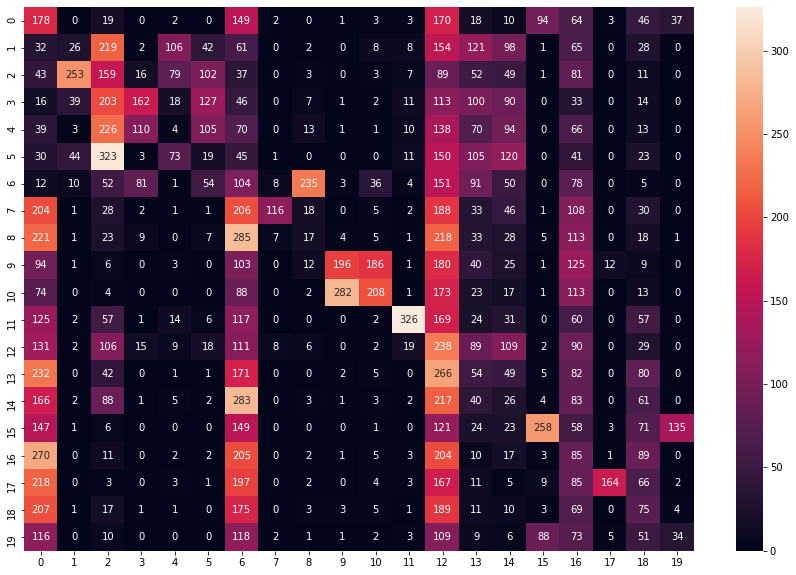

In [92]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(result_df['Target Name'],result_df['ClusterName'])
plt.figure(figsize = (15,10))
sn.heatmap(conf_mat, annot=True, fmt='d')


# Movie recommender

In [28]:
import pandas as pd
df = pd.read_csv('tmdb_5000_movies.csv')
df.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
budget                  4803 non-null int64
genres                  4803 non-null object
homepage                1712 non-null object
id                      4803 non-null int64
keywords                4803 non-null object
original_language       4803 non-null object
original_title          4803 non-null object
overview                4800 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4802 non-null object
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
status                  4803 non-null object
tagline                 3959 non-null object
title                   4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 non-null 

In [31]:
df = df[['title', 'tagline', 'overview', 'genres', 'popularity']]
df.tagline.fillna("", inplace=True)
df['description'] = df['tagline'].map(str) + ' ' + df['overview']
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4800 entries, 0 to 4802
Data columns (total 6 columns):
title          4800 non-null object
tagline        4800 non-null object
overview       4800 non-null object
genres         4800 non-null object
popularity     4800 non-null float64
description    4800 non-null object
dtypes: float64(1), object(5)
memory usage: 262.5+ KB


In [32]:
df.head()

,title,tagline,overview,genres,popularity,description
0,Avatar,Enter the World of Pandora.,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",150.437577,Enter the World of Pandora. In the 22nd centur...
1,Pirates of the Caribbean: At World's End,"At the end of the world, the adventure begins.","Captain Barbossa, long believed to be dead, ha...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",139.082615,"At the end of the world, the adventure begins...."
2,Spectre,A Plan No One Escapes,A cryptic message from Bond’s past sends him o...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",107.376788,A Plan No One Escapes A cryptic message from B...
3,The Dark Knight Rises,The Legend Ends,Following the death of District Attorney Harve...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",112.312950,The Legend Ends Following the death of Distric...
4,John Carter,"Lost in our world, found in another.","John Carter is a war-weary, former military ca...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",43.926995,"Lost in our world, found in another. John Cart..."


In [59]:
pop_movies = df.sort_values(by='popularity', ascending=False)
pop_movies.head()

,title,tagline,overview,genres,popularity,description
546,Minions,"Before Gru, they had a history of bad bosses","Minions Stuart, Kevin and Bob are recruited by...","[{""id"": 10751, ""name"": ""Family""}, {""id"": 16, ""...",875.581305,"Before Gru, they had a history of bad bosses M..."
95,Interstellar,Mankind was born on Earth. It was never meant ...,Interstellar chronicles the adventures of a gr...,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 18, ""...",724.247784,Mankind was born on Earth. It was never meant ...
788,Deadpool,Witness the beginning of a happy ending,Deadpool tells the origin story of former Spec...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",514.569956,Witness the beginning of a happy ending Deadpo...
94,Guardians of the Galaxy,All heroes start somewhere.,"Light years from Earth, 26 years after being a...","[{""id"": 28, ""name"": ""Action""}, {""id"": 878, ""na...",481.098624,All heroes start somewhere. Light years from E...
127,Mad Max: Fury Road,What a Lovely Day.,An apocalyptic story set in the furthest reach...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",434.278564,What a Lovely Day. An apocalyptic story set in...


## Text Preprocessing

In [35]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [36]:
import nltk
import re
import numpy as np
stop_words = nltk.corpus.stopwords.words('english')
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)
norm_corpus = normalize_corpus(list(df['description']))
len(norm_corpus)

4800

## Extract TF-IDF Features

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
tfidf_matrix = tf.fit_transform(norm_corpus)
tfidf_matrix.shape

(4800, 20667)

In [39]:
from sklearn.metrics.pairwise import cosine_similarity
doc_sim = cosine_similarity(tfidf_matrix)
doc_sim_df = pd.DataFrame(doc_sim)
doc_sim_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4760,4761,4762,4763,4764,4765,4766,4767,4768,4769,4770,4771,4772,4773,4774,4775,4776,4777,4778,4779,4780,4781,4782,4783,4784,4785,4786,4787,4788,4789,4790,4791,4792,4793,4794,4795,4796,4797,4798,4799
0,1.000000,0.010701,0.000000,0.019030,0.028687,0.024901,0.000000,0.026516,0.000000,0.007420,0.000000,0.013823,0.000000,0.000000,0.009263,0.000000,0.008344,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009415,0.000000,0.035881,0.047218,0.008047,0.026601,0.000000,0.062495,0.006680,0.000000,0.0,0.000000,0.063331,0.000000,0.000000,0.008586,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.049388,0.00000,0.000000,0.005816,0.000000,0.000000,0.000000,0.000000,0.012472,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.009702,0.0,0.023336,0.033549,0.000000,0.000000,0.0,0.006892,0.000000,0.000000
1,0.010701,1.000000,0.011891,0.000000,0.041623,0.000000,0.014564,0.027122,0.034688,0.007614,0.000000,0.000000,0.052134,0.009248,0.029468,0.004819,0.035518,0.032426,0.033918,0.000000,0.018308,0.000000,0.011241,0.020996,0.009661,0.042502,0.035897,0.024378,0.008258,0.006492,0.000000,0.012800,0.006855,0.000000,0.0,0.021532,0.016604,0.043655,0.016932,0.008811,...,0.012986,0.000000,0.000000,0.0,0.013762,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00643,0.010886,0.023603,0.030106,0.006809,0.000000,0.009489,0.017109,0.012248,0.017389,0.0,0.000000,0.0,0.000000,0.0,0.0,0.007478,0.022510,0.009956,0.0,0.004818,0.000000,0.000000,0.012593,0.0,0.022391,0.013724,0.000000
2,0.000000,0.011891,1.000000,0.000000,0.000000,0.000000,0.000000,0.022242,0.015854,0.004891,0.000000,0.083542,0.012713,0.011898,0.000000,0.003837,0.009272,0.032232,0.033011,0.000000,0.000000,0.000000,0.014462,0.014841,0.000000,0.000000,0.000000,0.000000,0.000000,0.090528,0.000000,0.023690,0.019635,0.000000,0.0,0.082010,0.013058,0.000000,0.022129,0.000000,...,0.014107,0.015918,0.021758,0.0,0.052869,0.0,0.015808,0.000000,0.0,0.004846,0.0,0.000000,0.00000,0.000000,0.010297,0.038254,0.010843,0.008621,0.000000,0.008626,0.022677,0.007735,0.0,0.000000,0.0,0.023521,0.0,0.0,0.005954,0.000000,0.042617,0.0,0.000000,0.000000,0.016519,0.000000,0.0,0.011682,0.000000,0.004000
3,0.019030,0.000000,0.000000,1.000000,0.008793,0.000000,0.015976,0.023172,0.027452,0.073610,0.000000,0.000000,0.000000,0.000000,0.000000,0.005932,0.015444,0.000000,0.004329,0.010927,0.005457,0.026736,0.000000,0.000000,0.015205,0.029242,0.015571,0.000000,0.006201,0.021761,0.015126,0.025419,0.020006,0.000000,0.0,0.000000,0.025365,0.000000,0.024300,0.009492,...,0.011328,0.015874,0.030060,0.0,0.025849,0.0,0.006226,0.010545,0.0,0.016889,0.0,0.000000,0.00000,0.000000,0.004482,0.000000,0.000000,0.000000,0.036303,0.000000,0.009426,0.009747,0.0,0.022818,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.009667,0.000000,0.000000,0.000000,0.0,0.028354,0.021785,0.027735
4,0.028687,0.041623,0.000000,0.008793,1.000000,0.000000,0.022912,0.028676,0.000000,0.023538,0.016695,0.000000,0.027047,0.013766,0.014130,0.000000,0.042218,0.026063,0.011792,0.016861,0.014546,0.000000,0.000000,0.000000,0.028304,0.000000,0.064792,0.046028,0.026343,0.019018,0.000000,0.019027,0.026188,0.036808,0.0,0.000000,0.037018,0.000000,0.000000,0.025814,...,0.009146,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.032717,0.0,0.000000,0.00000,0.000000,0.008873,0.000000,0.000000,0.000000,0.000000,0.009513,0.013763,0.007763,0.0,0.000000,0.0,0.000000,0.0,0.0,0.014875,0.018762,0.014800,0.0,0.000000,0.000000,0.000000,0.010760,0.0,0.010514,0.000000,0.000000


In [40]:
movies_list = df['title'].values
movies_list, movies_list.shape

(array(['Avatar', "Pirates of the Caribbean: At World's End", 'Spectre',
        ..., 'Signed, Sealed, Delivered', 'Shanghai Calling',
        'My Date with Drew'], dtype=object), (4800,))

## Find Top Similar Movies for a Sample Movie

In [46]:
movie_idx = np.where(movies_list == 'Minions')[0][0]
df.iloc[movie_idx,:]

title                                                    Minions
tagline             Before Gru, they had a history of bad bosses
overview       Minions Stuart, Kevin and Bob are recruited by...
genres         [{"id": 10751, "name": "Family"}, {"id": 16, "...
popularity                                               875.581
description    Before Gru, they had a history of bad bosses M...
Name: 546, dtype: object

In [51]:
movie_similarities = doc_sim_df.iloc[movie_idx].values
similar_movie_idxs = np.argsort(-movie_similarities)[1:6]
similar_movies = movies_list[similar_movie_idxs]
similar_movies

array(['Despicable Me 2', 'Despicable Me',
       'Teenage Mutant Ninja Turtles: Out of the Shadows', 'Superman',
       'Rise of the Guardians'], dtype=object)

In [0]:
def movie_recommender(movie_title, movies=movies_list, doc_sims=doc_sim_df):
    # find movie id
    movie_idx = np.where(movies == movie_title)[0][0]
    # get movie similarities
    movie_similarities = doc_sims.iloc[movie_idx].values
    # get top 5 similar movie IDs
    similar_movie_idxs = np.argsort(-movie_similarities)[1:6]
    # get top 5 movies
    similar_movies = movies[similar_movie_idxs]
    # return the top 5 movies
    return similar_movies

In [0]:
popular_movies = ['Minions', 'Interstellar', 'Deadpool', 'Jurassic World',
'Pirates of the Caribbean: The Curse of the Black Pearl',
'Dawn of the Planet of the Apes', 'The Hunger Games: Mockingjay - Part 1', 'Terminator Genisys', 'Captain America: Civil War', 'The Dark Knight', 'The Martian',
'Batman v Superman: Dawn of Justice', 'Pulp Fiction', 'The Godfather', 'The Shawshank Redemption', 'The Lord of the Rings: The Fellowship of the Ring', 'Harry Potter and the Chamber of Secrets', 'Star Wars', 'The Hobbit: The Battle of the Five Armies', 'Iron Man']

In [66]:
for movie in popular_movies:
    print('Movie:', movie)
    print('Top 5 recommended Movies:', movie_recommender(movie_title=movie))
    print()

Movie: Minions
Top 5 recommended Movies: ['Despicable Me 2' 'Despicable Me'
 'Teenage Mutant Ninja Turtles: Out of the Shadows' 'Superman'
 'Rise of the Guardians']

Movie: Interstellar
Top 5 recommended Movies: ['Gattaca' 'Space Pirate Captain Harlock' 'Space Cowboys'
 'Starship Troopers' 'Final Destination 2']

Movie: Deadpool
Top 5 recommended Movies: ['Silent Trigger' 'Underworld: Evolution' 'Bronson' 'Shaft' 'Don Jon']

Movie: Jurassic World
Top 5 recommended Movies: ['Jurassic Park' 'The Lost World: Jurassic Park' 'The Nut Job'
 "National Lampoon's Vacation" 'Vacation']

Movie: Pirates of the Caribbean: The Curse of the Black Pearl
Top 5 recommended Movies: ["Pirates of the Caribbean: Dead Man's Chest" 'The Pirate'
 'Pirates of the Caribbean: On Stranger Tides'
 'The Pirates! In an Adventure with Scientists!' 'Joyful Noise']

Movie: Dawn of the Planet of the Apes
Top 5 recommended Movies: ['Battle for the Planet of the Apes' 'Groove' 'The Other End of the Line'
 'Chicago Overcoat

## Using BM25

In [54]:
norm_corpus_tokens = np.array([nltk.word_tokenize(doc) for doc in norm_corpus])
norm_corpus_tokens[:3]

array([list(['enter', 'world', 'pandora', '22nd', 'century', 'paraplegic', 'marine', 'dispatched', 'moon', 'pandora', 'unique', 'mission', 'becomes', 'torn', 'following', 'orders', 'protecting', 'alien', 'civilization']),
       list(['end', 'world', 'adventure', 'begins', 'captain', 'barbossa', 'long', 'believed', 'dead', 'come', 'back', 'life', 'headed', 'edge', 'earth', 'turner', 'elizabeth', 'swann', 'nothing', 'quite', 'seems']),
       list(['plan', 'one', 'escapes', 'cryptic', 'message', 'bonds', 'past', 'sends', 'trail', 'uncover', 'sinister', 'organization', 'battles', 'political', 'forces', 'keep', 'secret', 'service', 'alive', 'bond', 'peels', 'back', 'layers', 'deceit', 'reveal', 'terrible', 'truth', 'behind', 'spectre'])],
      dtype=object)

In [0]:
from gensim.summarization.bm25 import get_bm25_weights
wts = get_bm25_weights(norm_corpus_tokens)

In [56]:
# viewing our pairwise similarity matrix
bm25_wts_df = pd.DataFrame(wts)
bm25_wts_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4760,4761,4762,4763,4764,4765,4766,4767,4768,4769,4770,4771,4772,4773,4774,4775,4776,4777,4778,4779,4780,4781,4782,4783,4784,4785,4786,4787,4788,4789,4790,4791,4792,4793,4794,4795,4796,4797,4798,4799
0,134.330248,2.350440,0.000000,3.876951,5.558033,4.633487,0.000000,4.665305,0.000000,1.799157,0.000000,3.202913,0.000000,0.000000,2.208006,0.000000,2.024026,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.143073,0.000000,6.616696,7.199213,2.350440,5.084540,0.000000,9.188448,1.518063,0.000000,0.0,0.000000,9.882889,0.000000,0.000000,2.112017,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,7.446112,0.000000,0.000000,1.442917,0.000000,0.000000,0.000000,0.000000,2.598611,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,2.388966,0.0,3.653099,5.094959,0.000000,0.000000,0.0,1.694565,0.000000,0.000000
1,2.428777,111.427678,2.658433,0.000000,7.100393,0.000000,2.691418,5.979995,5.045886,1.799157,0.000000,0.000000,8.903081,2.215404,6.098864,1.359625,7.826140,7.008096,6.729671,0.000000,3.436677,0.000000,2.819531,3.856219,2.143073,7.443521,6.520992,4.884759,2.350440,1.534041,0.000000,2.512516,1.518063,0.000000,0.0,5.072820,3.250656,8.929413,3.958405,2.112017,...,2.896464,0.000000,0.000000,0.0,3.088831,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.556392,1.819749,5.093861,5.283778,1.598452,0.000000,2.039343,3.711954,2.383335,3.626775,0.0,0.000000,0.0,0.000000,0.0,0.0,1.819749,3.837466,2.388966,0.0,1.115938,0.000000,0.000000,2.832942,0.0,4.742954,3.038859,0.000000
2,0.000000,3.001412,150.265248,0.000000,0.000000,0.000000,0.000000,4.700045,4.068769,1.438743,0.000000,18.154207,3.208377,3.602768,0.000000,1.339528,2.584596,7.711448,6.845081,0.000000,0.000000,0.000000,4.585220,3.521476,0.000000,0.000000,0.000000,0.000000,0.000000,17.720326,0.000000,4.692821,3.741572,0.000000,0.0,16.300043,3.193301,0.000000,5.834479,0.000000,...,2.952895,4.004193,4.789099,0.0,10.868986,0.0,4.468221,0.000000,0.0,1.421199,0.0,0.000000,0.000000,0.000000,2.996410,7.941343,2.244965,2.080945,0.000000,2.269433,4.833386,1.754843,0.0,0.000000,0.0,4.659777,0.0,0.0,1.792850,0.000000,7.761946,0.0,0.000000,0.000000,3.567322,0.000000,0.0,2.933405,0.000000,1.421199
3,5.621343,0.000000,0.000000,221.970735,3.203591,0.000000,5.857063,7.082597,6.399534,19.010811,0.000000,0.000000,0.000000,0.000000,0.000000,2.249035,4.726007,0.000000,1.837568,3.377175,2.318858,6.597449,0.000000,0.000000,5.512265,5.853737,4.620393,0.000000,3.022940,7.496254,5.593095,6.226702,4.755152,0.000000,0.0,0.000000,7.988645,0.000000,8.721955,3.528555,...,3.247923,5.102840,6.321325,0.0,8.273860,0.0,2.624414,2.770786,0.0,6.094649,0.0,0.000000,0.000000,0.000000,1.855760,0.000000,0.000000,0.000000,8.142302,0.000000,2.944673,3.087439,0.0,7.586714,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,3.000065,0.000000,0.000000,0.000000,0.0,8.411518,7.025269,7.383788
4,8.408860,10.028231,0.000000,2.798577,182.119640,0.000000,5.571275,7.536868,0.000000,6.828038,4.315626,0.000000,5.694704,3.591367,4.416013,0.000000,9.918775,7.400805,3.004118,3.695291,4.621189,0.000000,0.000000,0.000000,7.866584,0.000000,16.200554,11.335295,9.090977,5.631009,0.000000,5.025033,6.505182,9.056566,0.0,0.000000,8.425284,0.000000,0.000000,7.752589,...,2.368857,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,8.904814,0.0,0.000000,0.000000,0.000000,2.885834,0.000000,0.000000,0.000000,0.000000,2.598611,3.107482,2.185597,0.0,0.000000,0.0,0.000000,0.0,0.0,4.024633,4.132472,4.777933,0.0,0.000000,0.000000,0.000000,3.114387,0.0,3.389130,0.000000,0.000000


In [0]:
for movie in popular_movies:
    print('Movie:', movie)
    print('BM25 recommended Movies:', movie_recommender(movie_title=movie,
                                                         doc_sims=bm25_wts_df))
    print('Cosine Similarity recommended Movies:', movie_recommender(movie_title=movie))
    print()